# Portfolio Analysis

This is just out of curiosity and just for fun, i.e., **this is not financial advice**.

In this notebook, I compute a **Markowitz portfolio optimization** for three selected cryptocurrencies: BTC, ETH, XMR.
I chose those due to their value proposition, explained in the previous notebook `01_BitcoinAnalysis`:
- BTC: alternative open currency
- ETH: general blockchain
- XMR: alternative private currency

The Markowitz portfolio optimization consists in performing a **Monte Carlo Simulation** in the portfolio allocation space (i.e., the ratio assigned to each of the selected assets) to obtain the return and volatility (variance) values of each simulated sample.
The best allocation is the one with the highest Sharpe ratio, which is basically the risk adjusted return:

$S = \frac{R_p - R_f}{\sigma_p}$, where

- $R_p$: expected portfolio return
- $R_f$: risk-free return: return we would have had if we had put our money in an investment such as savings account, EURIBOR, or treasury bonds that are considered to be risk free. In the EU, the EURIBOR is currently (Dec. 2021) -0.5%, i.e., one bank **pays** a fee of -0.5% when it lends money to another one
- $\sigma_p$: portfolio standard deviation

So, the higher $S$ the better, because we'd have high returns with low volatility!

Note that William Sharpe (Nobel laureate) originally presented the formula for **yearly returns**: *mean* daily returns and std. dev. of the whole year. However, we deal often with daily, weekly and monthly sampling series, thus the **Anualized Sharpe Ratio** is obtained by multiplying the Sharpe ratio with the following k constant:

`ASR = k * S`

k = 
- `sqrt(252)` for daily sampling series (stocks, since traded during working days)
- `sqrt(365)` for daily sampling series (cryptos, since traded daily) -- or that's what I understand; however, I am not sure, since we apply that to an average, and 252 seems to be a standardized constant...?
- `sqrt(52)` for weekly sampling series
- `sqrt(12)` for monthly sampling series

This is important when Sharpe Ratios are compared between each other.
Typical interpretation of the Annualized Sharpe Ratio (ASR) values:
- 1: go-to for investors
- 2: very good
- 3: excellent

Note that I learned most of the concepts used here from José Portilla's videos in [Python for Financial Analysis and Algorithmic Trading](https://www.udemy.com/course/python-for-finance-and-trading-algorithms/) and Robert Shiller's Coursera course [Financial Markets](https://www.coursera.org/learn/financial-markets-global).

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

In [90]:
# Load and prepare datasets
df_btc = pd.read_csv('data/Gemini_BTCUSD_2015_2021_hourly.csv',header=0)
df_btc['Date'] = pd.to_datetime(df_btc['Date'])
df_btc.set_index('Date',inplace=True)
df_eth = pd.read_csv('data/Bitstamp_ETHUSD_2017_2021_hourly.csv',header=0)
df_eth['Date'] = pd.to_datetime(df_eth['Date'])
df_eth.set_index('Date',inplace=True)
df_xmr = pd.read_csv('data/Binance_XMRUSD_2020_2021_hourly.csv',header=0)
df_xmr['Date'] = pd.to_datetime(df_xmr['Date'])
df_xmr.set_index('Date',inplace=True)

In [91]:
df_btc.head()

,Open,High,Low,Close,Volume BTC
Date,,,,,
2015-10-08 13:00:00,0.00,245.00,0.00,245.00,0.606654
2015-10-08 14:00:00,245.00,245.00,244.50,245.00,4.453649
2015-10-08 15:00:00,245.00,245.00,244.92,244.92,3.016926
2015-10-08 16:00:00,244.92,244.92,244.25,244.25,3.895252
2015-10-08 17:00:00,244.25,244.99,244.02,244.99,3.920632


In [92]:
df_eth.head()

,Open,High,Low,Close,Volume ETH,Volume USD
Date,,,,,,
2017-08-16 16:00:00,300.0,300.0,300.0,300.0,0.02,6.0
2017-08-16 17:00:00,300.0,300.0,300.0,300.0,0.00,0.0
2017-08-16 18:00:00,300.0,300.0,300.0,300.0,0.00,0.0
2017-08-16 19:00:00,300.0,300.0,300.0,300.0,0.00,0.0
2017-08-16 20:00:00,300.0,300.0,300.0,300.0,0.00,0.0


In [93]:
df_xmr.head()

,Open,High,Low,Close,Volume XMR,Volume USDT
Date,,,,,,
2020-02-03 08:00:00,75.81,77.21,75.70,76.66,9094.826,6.973109e+05
2020-02-03 09:00:00,76.66,76.74,75.98,76.12,10198.387,7.793740e+05
2020-02-03 10:00:00,76.12,76.60,75.92,76.50,14820.044,1.128870e+06
2020-02-03 11:00:00,76.50,78.27,76.33,77.44,18219.038,1.409690e+06
2020-02-03 12:00:00,77.44,77.99,77.35,77.39,13923.253,1.081595e+06


In [123]:
# Compute maximum possible rane in the data we have
date_start = max(df_btc.index[0], df_eth.index[0], df_xmr.index[0])
date_end = min(df_btc.index[-1], df_eth.index[-1], df_xmr.index[-1])

In [124]:
# Take daily close values
df = pd.DataFrame()
df["BTC"] = df_btc["Close"].resample(rule='D').last().loc[date_start:date_end]
df["ETH"] = df_eth["Close"].resample(rule='D').last().loc[date_start:date_end]
df["XMR"] = df_xmr["Close"].resample(rule='D').last().loc[date_start:date_end]

In [125]:
df.head()

,BTC,ETH,XMR
Date,,,
2020-02-04,9167.01,188.15,75.27
2020-02-05,9615.04,203.54,77.87
2020-02-06,9635.73,213.09,78.39
2020-02-07,9816.97,223.43,79.63
2020-02-08,9912.53,223.20,80.77


In [126]:
# Get number of datapoints
num_datapoints = df.shape[0]
print(num_datapoints)
print(df.pct_change(1).mean())

645
BTC    0.004011
ETH    0.006642
XMR    0.003786
dtype: float64


In [127]:
# Compute the correlation of the returns
# It should be low...
df.pct_change(1).corr()

,BTC,ETH,XMR
BTC,1.000000,0.774262,0.707028
ETH,0.774262,1.000000,0.677451
XMR,0.707028,0.677451,1.000000


In [128]:
date_start

Timestamp('2020-02-03 08:00:00')

In [129]:
date_end

Timestamp('2021-11-09 07:00:00')

In [130]:
# Since the Sharpe Ratio interpretation seems to be standardized to one year,
# it makes sense to reduce the analysis period to one year
#start = df.index[0]
start = dt.datetime(2020,10,1)
end = start + dt.timedelta(days=365-1)
df = df.loc[start:end]

In [131]:
num_datapoints = df.shape[0]
print(num_datapoints)
print(df.pct_change(1).mean())

365
BTC    0.004775
ETH    0.007461
XMR    0.004426
dtype: float64


**Logarithmic vs arithmetic returns**: `pct_change(1)` gives the arithmetic return, which is often used. However, it is also common to use logarithmic returns to have normalized time series. I use here the logarithmic version.

In [132]:
# Logarithmic returns
ret = np.log(df/df.shift(1))

In [133]:
ret.corr()

,BTC,ETH,XMR
BTC,1.000000,0.764775,0.665666
ETH,0.764775,1.000000,0.655291
XMR,0.665666,0.655291,1.000000


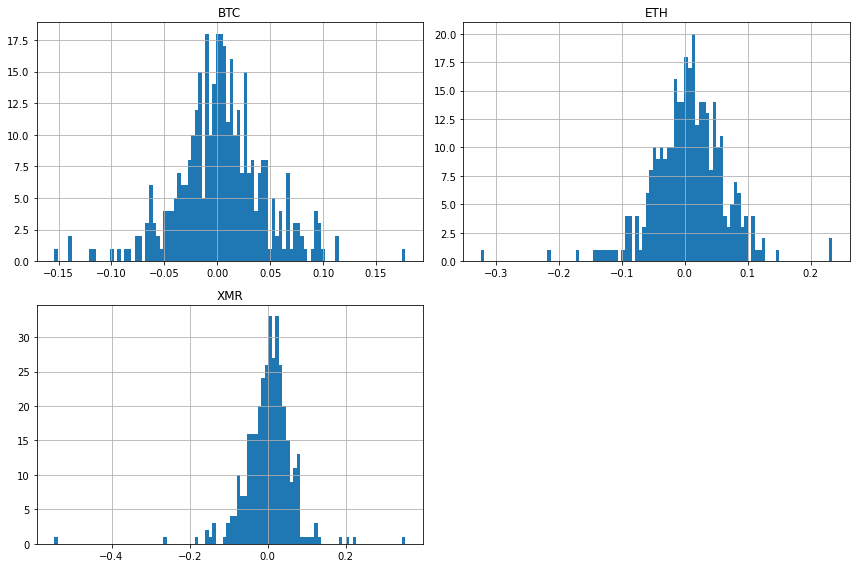

In [134]:
# Plot histograms of log returns
ret.hist(bins=100,figsize=(12,8))
plt.tight_layout()

In [135]:
# Arithmetic mean of log returns
ret.mean()

BTC    0.003892
ETH    0.005944
XMR    0.002629
dtype: float64

In [136]:
# Covariance
ret.cov()

,BTC,ETH,XMR
BTC,0.001749,0.001856,0.001776
ETH,0.001856,0.003339,0.002473
XMR,0.001776,0.002473,0.004099


### Single Random Portfolio Test

In [137]:
# Random weights = allocation ratios
np.random.seed(73)
weights = np.array(np.random.random(3))
weights /= weights.sum()
print(df.columns)
print(weights)

Index(['BTC', 'ETH', 'XMR'], dtype='object')
[0.3795692  0.31810662 0.30232419]


Now, the portfolio gain and its Sharpe ratio are computed.
For computing the volatility, the **covariance matrix** should be used;
that way, the cross-variances are also taken into account.
Additionally, note that we take them **mean** of the returns;
if we want to align the computation with the standard annualized Sharpe ratio, we need to multiply it by the corresponding factor that yields a year.
Traditionally, that would be `k = 252`; in crypto, is that `k = 365`?

Another issue is the risk free interest:

Linear: $r = \frac{p_1}{p_0} - 1$

Logarithmic: $\rho = ln(\frac{p_1}{p_0}) = ln(r + 1)$

In [138]:
#k = 252
#k = 365
k = num_datapoints

In [139]:
# Expected portfolio return
expected_ret = np.sum((ret.mean()*weights)*k)
# Expected volatility: sqrt(w*C*w)
expected_vol = np.sqrt(np.dot(weights.T,np.dot(ret.cov()*k,weights)))
# Sharpe Ratio
#RF = 0.0
#RF = -0.005
RF = np.log(-0.005 + 1) 
SR = (expected_ret-RF) / expected_vol
print(SR)

1.6652463058693996


### Markowitz Portofolio Optimization: Monte Carlo Simulation

In [140]:
# We run the previous code in a for loop N times
num_portfolios = 5000
#RF = 0.0
#RF = -0.005
RF = np.log(-0.005 + 1)
weights_array = np.zeros((num_portfolios,len(df.columns)))
ret_array = np.zeros(num_portfolios)
vol_array = np.zeros(num_portfolios)
sharpe_array = np.zeros(num_portfolios)
for i in range(num_portfolios):
    # Weights
    weights = np.array(np.random.random(len(df.columns)))
    weights /= weights.sum()
    weights_array[i,:] = weights
    # Expected return (annual)
    ret_array[i] = np.sum((log_ret.mean()*weights)*k)
    # Expected volatility (annual)
    vol_array[i] = np.sqrt(np.dot(weights.T,np.dot(log_ret.cov()*k,weights)))
    # Sharpe ratio: adjusted risk
    sharpe_array[i] = (ret_array[i]-RF) / vol_array[i]

In [141]:
# Maximum Sharpe Ratio in our simulation
# It is 1.03: ok, but not really good
sharpe_array.max()

1.8365729851286594

In [142]:
# Weights/Allocation ratios of maxium SR
# We see the optimum allocation we would require
weights_array[sharpe_array.argmax()]

array([0.10020937, 0.89584941, 0.00394121])

Text(0, 0.5, 'Return')

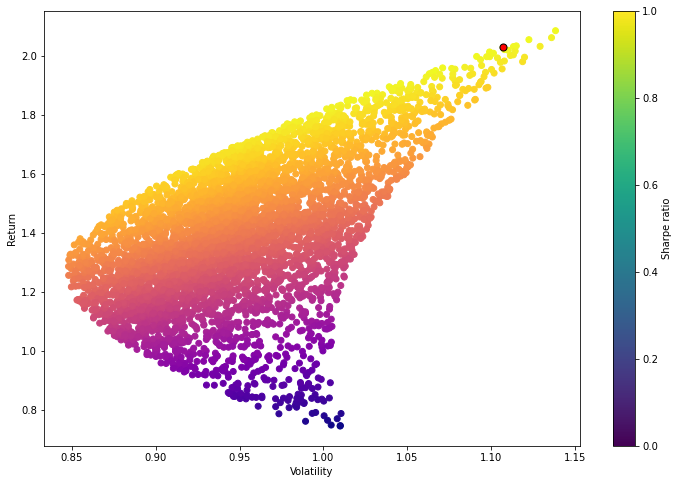

In [143]:
# Plot results
# The maximum point is a tangent point of the efficient frontier
# The efficient frontier is the set of points that lead to
# maximum returns for a given volatility
# If we move right: we have the same returns for higher volatility
# If we move down: we have less returns for the same volatility
# In general, we want the highest returns possible for the lowest volatility
plt.figure(figsize=(12,8))
# All points
plt.scatter(vol_array,ret_array,c=sharpe_array,cmap='plasma')
# Max SR point
plt.scatter(vol_array[sharpe_array.argmax()],ret_array[sharpe_array.argmax()],c='red',s=50,edgecolors='black')
plt.colorbar(label='Sharpe ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')